#  CE-40959: Deep Learning

## Homework 5 - 1: VAE

The goal is to VAE!!!!

Good luck

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

---

In [4]:
cpu = True
BATCH_SIZE = 128
LEARNING_RATE = 0.01
dropout_rate = 0.2

---

In [5]:
# Reproducibility options

np.random.seed(0)
torch.manual_seed(0)

if cpu:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

---

In [6]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

In [7]:
# Define Train loader
train_tensors = original_train_dataset.data.float() / 255
test_tensors = original_test_dataset.data.float() / 255

# Define Datasets
train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

# Define dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

---

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, encoder_dims, z_dim, decoder_dims, dropout_rate):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.p = dropout_rate
        
        
        ########################## TODO ##########################
        # self.input_dropout must be a dropout module with p=dropout_rate
        pass
        #self.input_dropout = nn.modules.dropout(p = self.p)
        
        # Encoder part
        #encoder_layers = []
        ########################## TODO ##########################
        # Define encoder layers and add them to `encoder_layers`
        # Use ReLU for activation functions
        pass
       
        self.encoder = nn.Sequential(
            
            nn.Linear(input_dim, encoder_dims[0]),
            nn.ReLU(),
            nn.Linear(encoder_dims[0], encoder_dims[1]),
            nn.ReLU()
        )
        
        encoder_last_dim = ([input_dim] + encoder_dims)[-1]
        
        # mu and log_var
        ########################## TODO ##########################
        # Define mu and log_var layers
        # They do not need any activation function
        #pass
        self.mu = nn.Linear(encoder_last_dim, z_dim)  # mu layer
        self.log_var = nn.Linear(encoder_last_dim, z_dim)  # logvariance layer
        
        # Decoder part
        #decoder_layers = []
        ########################## TODO ##########################
        # Define decoder layers and add them to `decoder_layers`
        # Use ReLU for activation functions
        # Last layer does not need any activation function
        pass
        ######################## END TODO ########################
        self.decoder = nn.Sequential(
        
            nn.Linear(z_dim, encoder_dims[1]),
            nn.ReLU(),
            nn.Linear(encoder_dims[1], encoder_dims[0]),
            nn.ReLU(),
            nn.Linear(encoder_dims[0], input_dim),
            nn.Sigmoid()
        )

    @staticmethod
    def _sampling(self, mu, log_var):
        """
        This function is in charge of reparametrization trick
        """
        ########################## TODO ##########################
        # Generate a random z from N(mu=mu, var=e^log_var)
        pass
    
        if self.training:
            std = log_var.mul(0.5).exp_()  # type: Variable
            eps = Variable(std.data.new(std.size()).normal_())
        
            return eps.mul(std).add_(mu)
        
        else:
            return mu

    def forward(self, data):
        x = data
        ########################## TODO ##########################
        # Complete the flow
        # x > dropout > encoder > mu, log_var > z > decoder > output
        pass
        
        dropouted = F.dropout(x, self.p, self.training)
        encoded = self.encoder(dropouted)
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        
        z = self._sampling(self,mu,log_var)
        output = self.decoder(z)
        output = {"X": output, "mu": mu, "log_var": log_var, "z": z}
        return output
    
    def loss(self, data, output):
        x = data
        recon_x = output["X"]
        mu = output["mu"]
        log_var = output["log_var"]
        ########################## TODO ##########################
        pass
        BCE = F.binary_cross_entropy(recon_x, x)
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        KLD /= BATCH_SIZE * self.input_dim
        return {"final": BCE + KLD, "KLD": KLD, "BCE": BCE}

---

In [9]:
def train(model, data_loader, optimizer, epoch="?", print_every=100, verbose=True):
    """
    This function trains a `model` given a `data_loader` by `optimizer`
    """
    model.train()

    train_loss = 0

    for batch_idx, batch_data in enumerate(data_loader):
        supervised_training = len(batch_data) == 2

        if supervised_training:
            # Labeled data
            data = {"X": batch_data[0],
                    "Y": batch_data[1]}
            
        else:
            # Unlabeled data
            data = {"X": batch_data[0]}

        # Flatten data
        ########################## TODO ##########################
        # Use `flatten` function from pytorch
        pass
    
        data = data["X"].view(-1, 784)

        if cpu:
            ########################## TODO ##########################
            # Send tensors in data to GPU
            pass
            data = data.cpu()

        
        ########################## TODO ##########################
        # Think about this part
        ######################## END TODO ########################
        optimizer.zero_grad()

        output = model(data)
        loss = model.loss(data, output)
        final_loss = loss["final"]
        train_loss += final_loss.item()

        final_loss.backward()
        optimizer.step()
        ########################## TODO ##########################
        # Thinking ends here
        ######################## END TODO ########################

        if batch_idx % print_every == 0 and verbose:
            print('Train | Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), final_loss.item() / len(data)))

    train_loss /= len(data_loader.dataset)
    if verbose:
        print('====> Train | Epoch: {} \t | \t Average loss: {:.4f}'.format(epoch, train_loss,))

    return {"final": train_loss}

In [10]:
def test(model, data_loader, verbose=True):
    """
    This function tests a `model` on a `data_loader`
    """
    model.eval()

    test_loss = 0

    labels, y_preds = None, None
    with torch.no_grad():
        for batch_data  in data_loader:
            supervised = len(batch_data) == 2

            if supervised:
                # Labeled data
                data = {"X": batch_data[0],
                        "Y": batch_data[1]}
            else:
                # Unlabeled data
                data = {"X": batch_data[0]}

            #  Flatten data
            ########################## TODO ##########################
            # Use `flatten` function from pytorch
            pass
            data = data["X"].view(-1, 784)

            if cpu:
                ########################## TODO ##########################
                # Send tensors in data to cpu
                pass
                data = data.cpu()

            output = model(data)
            loss = model.loss(data, output)
            final_loss = loss["final"]
            test_loss += final_loss.item()
            
            # Storing y_true and y_pred if learning is supervised
            supervised = supervised and "Y" in output
            if supervised:
                y_pred = np.argmax(output["Y"].detach().cpu().numpy(), axis=1)
                y_true = data["Y"].cpu().numpy()
                if labels is None:
                    labels = y_true
                    y_preds = y_pred
                else:
                    labels = np.concatenate((labels, y_true), axis=None)
                    y_preds = np.concatenate((y_preds, y_pred), axis=None)
            
    test_loss /= len(data_loader.dataset)

    if supervised:
        accuracy = accuracy_score(labels, y_preds)
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
            print('            |   accuracy: {:.4f}'.format(100 * accuracy))
            print(classification_report(labels, y_preds))
        return {"final": test_loss, "accuracy": accuracy}
    else:
        if verbose:
            print('====> Test  | model loss: {:.4f}'.format(test_loss))
        return {"final": test_loss}

In [11]:
def run(model, parameters, n_epoch, train_loader, test_loader,
        end_function=lambda model:None):
    """
    This function will optimize `parameters` of `model` for `n_epoch` epochs
    on `train_loader` dataset and validate it on `test_loader`.
    At the end of each epoch, `end_function` will be called on `model`.
    """
    if cpu:
        model.cpu()

    ########################## TODO ##########################
    # Initialize a new Adam optimizer.
    # Set learning rate to LEARNING_RATE / BATCH_SIZE (why?)
    pass
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE / BATCH_SIZE)


    for epoch in range(1, n_epoch + 1):
        train_loss = train(model, train_loader, optimizer, epoch)
        test_loss = test(model, test_loader)
        end_function(model)

In [12]:
def show(image_batch, rows=1):
    # Set Plot dimensions
    cols = np.ceil(image_batch.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (0.0 + cols, 0.0 + rows) # set default size of plots
    
    for i in range(image_batch.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

---

In [13]:
vae = VAE(784, encoder_dims=[512, 128], z_dim=32, decoder_dims=[128, 512], dropout_rate = dropout_rate)
print(vae)

# Output might be like:
# VAE(
#   (input_dropout): Dropout(p=0.2)
#   (encoder): Sequential(
#     (0): Linear(in_features=784, out_features=512, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=512, out_features=128, bias=True)
#     (3): ReLU()
#   )
#   (mu_layer): Linear(in_features=128, out_features=32, bias=True)
#   (log_var_layer): Linear(in_features=128, out_features=32, bias=True)
#   (decoder): Sequential(
#     (0): Linear(in_features=32, out_features=128, bias=True)
#     (1): ReLU()
#     (2): Linear(in_features=128, out_features=512, bias=True)
#     (3): ReLU()
#     (4): Linear(in_features=512, out_features=784, bias=True)
#   )
# )

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=128, out_features=32, bias=True)
  (log_var): Linear(in_features=128, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [14]:
def show_vae(vae):
    # Select 10 random inputs
    data_loader = train_loader
    indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (10,))
    input_img = data_loader.dataset.tensors[0][indices]
    print("Inputs:")
    show(input_img.numpy())
    # Calculate reconstructions
    input_img = input_img.flatten(start_dim=1)
    if cpu:
        input_img = input_img.cpu()
    #recons_img = vae({"X": input_img})["X"]
    recons_img = vae(input_img)
    recons_img = recons_img["X"].detach().cpu().view(-1, 28, 28).numpy()
    print("Reconstructions:")
    show(recons_img)
    # Generate images
    z = torch.randn(10, vae.z_dim)
    if cpu:
        z = z.cpu()
    generated_img = vae.decoder(z)
    generated_img = generated_img.detach().cpu().view(-1, 28, 28).numpy()
    print("Generated Images:")
    show(generated_img)

Train | Epoch: 1 [0/60000 (0%)]	Loss: 0.005424
Train | Epoch: 1 [12800/60000 (21%)]	Loss: 0.002552
Train | Epoch: 1 [25600/60000 (43%)]	Loss: 0.002201
Train | Epoch: 1 [38400/60000 (64%)]	Loss: 0.002143
Train | Epoch: 1 [51200/60000 (85%)]	Loss: 0.002100
====> Train | Epoch: 1 	 | 	 Average loss: 0.0025
====> Test  | model loss: 0.0025
Inputs:


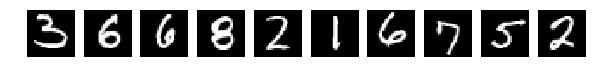

Reconstructions:


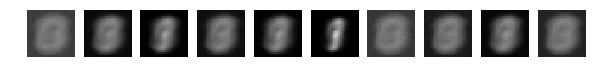

Generated Images:


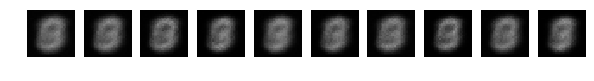

Train | Epoch: 2 [0/60000 (0%)]	Loss: 0.002073
Train | Epoch: 2 [12800/60000 (21%)]	Loss: 0.001873
Train | Epoch: 2 [25600/60000 (43%)]	Loss: 0.001914
Train | Epoch: 2 [38400/60000 (64%)]	Loss: 0.001874
Train | Epoch: 2 [51200/60000 (85%)]	Loss: 0.001923
====> Train | Epoch: 2 	 | 	 Average loss: 0.0019
====> Test  | model loss: 0.0020
Inputs:


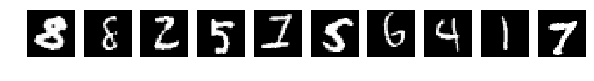

Reconstructions:


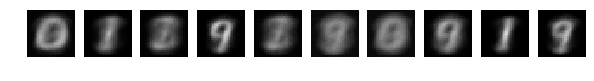

Generated Images:


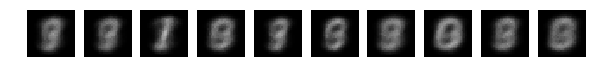

Train | Epoch: 3 [0/60000 (0%)]	Loss: 0.001876
Train | Epoch: 3 [12800/60000 (21%)]	Loss: 0.001860
Train | Epoch: 3 [25600/60000 (43%)]	Loss: 0.001855
Train | Epoch: 3 [38400/60000 (64%)]	Loss: 0.001836
Train | Epoch: 3 [51200/60000 (85%)]	Loss: 0.001877
====> Train | Epoch: 3 	 | 	 Average loss: 0.0018
====> Test  | model loss: 0.0018
Inputs:


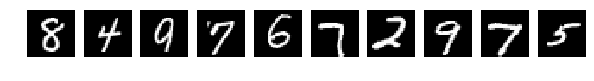

Reconstructions:


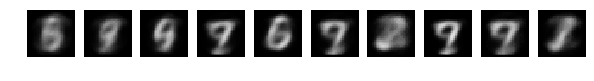

Generated Images:


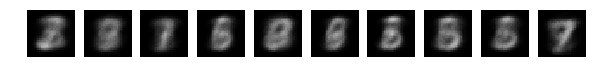

Train | Epoch: 4 [0/60000 (0%)]	Loss: 0.001774
Train | Epoch: 4 [12800/60000 (21%)]	Loss: 0.001707
Train | Epoch: 4 [25600/60000 (43%)]	Loss: 0.001714
Train | Epoch: 4 [38400/60000 (64%)]	Loss: 0.001655
Train | Epoch: 4 [51200/60000 (85%)]	Loss: 0.001652
====> Train | Epoch: 4 	 | 	 Average loss: 0.0017
====> Test  | model loss: 0.0016
Inputs:


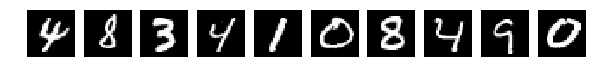

Reconstructions:


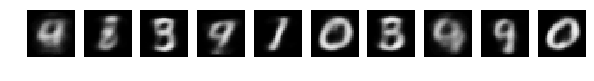

Generated Images:


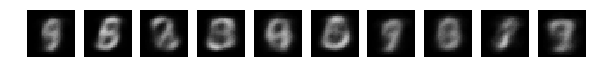

Train | Epoch: 5 [0/60000 (0%)]	Loss: 0.001593
Train | Epoch: 5 [12800/60000 (21%)]	Loss: 0.001603
Train | Epoch: 5 [25600/60000 (43%)]	Loss: 0.001651
Train | Epoch: 5 [38400/60000 (64%)]	Loss: 0.001623
Train | Epoch: 5 [51200/60000 (85%)]	Loss: 0.001498
====> Train | Epoch: 5 	 | 	 Average loss: 0.0016
====> Test  | model loss: 0.0015
Inputs:


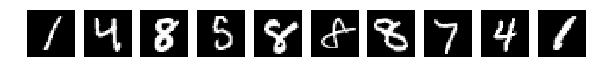

Reconstructions:


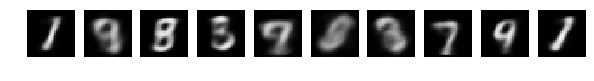

Generated Images:


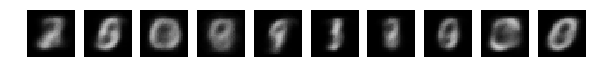

Train | Epoch: 6 [0/60000 (0%)]	Loss: 0.001618
Train | Epoch: 6 [12800/60000 (21%)]	Loss: 0.001510
Train | Epoch: 6 [25600/60000 (43%)]	Loss: 0.001554
Train | Epoch: 6 [38400/60000 (64%)]	Loss: 0.001565
Train | Epoch: 6 [51200/60000 (85%)]	Loss: 0.001557
====> Train | Epoch: 6 	 | 	 Average loss: 0.0015
====> Test  | model loss: 0.0014
Inputs:


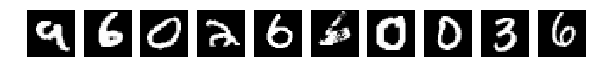

Reconstructions:


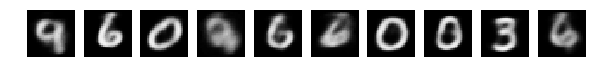

Generated Images:


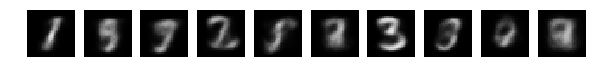

Train | Epoch: 7 [0/60000 (0%)]	Loss: 0.001510
Train | Epoch: 7 [12800/60000 (21%)]	Loss: 0.001510
Train | Epoch: 7 [25600/60000 (43%)]	Loss: 0.001516
Train | Epoch: 7 [38400/60000 (64%)]	Loss: 0.001498
Train | Epoch: 7 [51200/60000 (85%)]	Loss: 0.001474
====> Train | Epoch: 7 	 | 	 Average loss: 0.0015
====> Test  | model loss: 0.0014
Inputs:


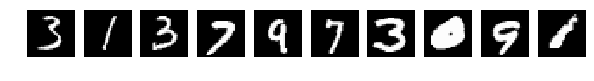

Reconstructions:


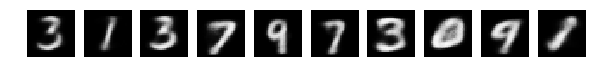

Generated Images:


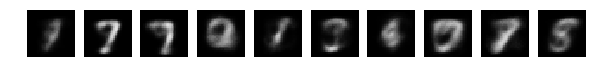

Train | Epoch: 8 [0/60000 (0%)]	Loss: 0.001484
Train | Epoch: 8 [12800/60000 (21%)]	Loss: 0.001442
Train | Epoch: 8 [25600/60000 (43%)]	Loss: 0.001417
Train | Epoch: 8 [38400/60000 (64%)]	Loss: 0.001450
Train | Epoch: 8 [51200/60000 (85%)]	Loss: 0.001462
====> Train | Epoch: 8 	 | 	 Average loss: 0.0014
====> Test  | model loss: 0.0013
Inputs:


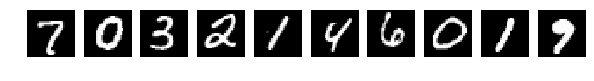

Reconstructions:


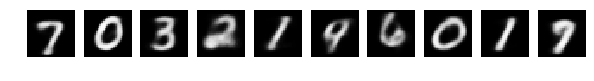

Generated Images:


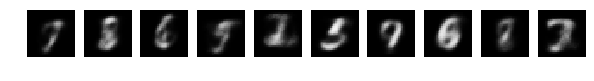

Train | Epoch: 9 [0/60000 (0%)]	Loss: 0.001424
Train | Epoch: 9 [12800/60000 (21%)]	Loss: 0.001425
Train | Epoch: 9 [25600/60000 (43%)]	Loss: 0.001396
Train | Epoch: 9 [38400/60000 (64%)]	Loss: 0.001360
Train | Epoch: 9 [51200/60000 (85%)]	Loss: 0.001400
====> Train | Epoch: 9 	 | 	 Average loss: 0.0014
====> Test  | model loss: 0.0013
Inputs:


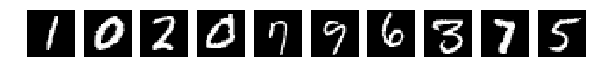

Reconstructions:


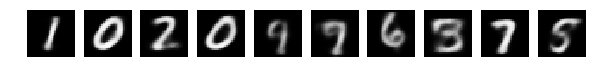

Generated Images:


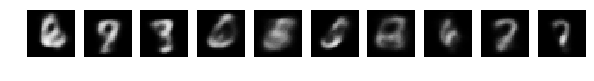

Train | Epoch: 10 [0/60000 (0%)]	Loss: 0.001427
Train | Epoch: 10 [12800/60000 (21%)]	Loss: 0.001347
Train | Epoch: 10 [25600/60000 (43%)]	Loss: 0.001370
Train | Epoch: 10 [38400/60000 (64%)]	Loss: 0.001422
Train | Epoch: 10 [51200/60000 (85%)]	Loss: 0.001414
====> Train | Epoch: 10 	 | 	 Average loss: 0.0014
====> Test  | model loss: 0.0013
Inputs:


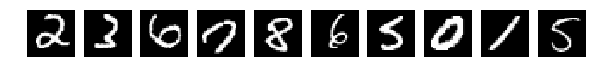

Reconstructions:


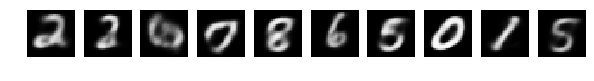

Generated Images:


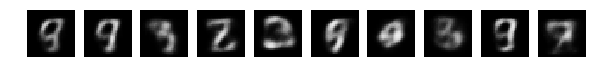

Train | Epoch: 11 [0/60000 (0%)]	Loss: 0.001413
Train | Epoch: 11 [12800/60000 (21%)]	Loss: 0.001353
Train | Epoch: 11 [25600/60000 (43%)]	Loss: 0.001370
Train | Epoch: 11 [38400/60000 (64%)]	Loss: 0.001321
Train | Epoch: 11 [51200/60000 (85%)]	Loss: 0.001340
====> Train | Epoch: 11 	 | 	 Average loss: 0.0014
====> Test  | model loss: 0.0012
Inputs:


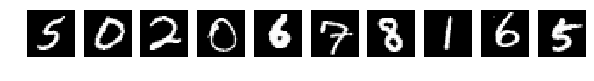

Reconstructions:


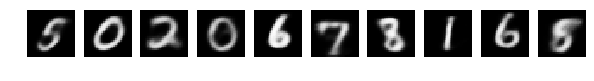

Generated Images:


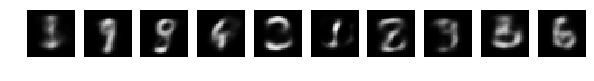

Train | Epoch: 12 [0/60000 (0%)]	Loss: 0.001339
Train | Epoch: 12 [12800/60000 (21%)]	Loss: 0.001302
Train | Epoch: 12 [25600/60000 (43%)]	Loss: 0.001334
Train | Epoch: 12 [38400/60000 (64%)]	Loss: 0.001360
Train | Epoch: 12 [51200/60000 (85%)]	Loss: 0.001299
====> Train | Epoch: 12 	 | 	 Average loss: 0.0013
====> Test  | model loss: 0.0012
Inputs:


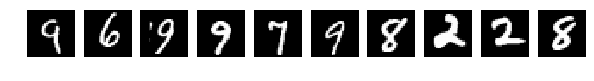

Reconstructions:


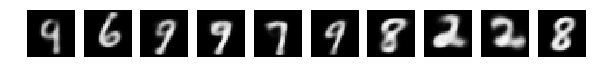

Generated Images:


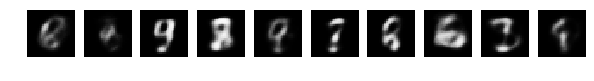

Train | Epoch: 13 [0/60000 (0%)]	Loss: 0.001297
Train | Epoch: 13 [12800/60000 (21%)]	Loss: 0.001348
Train | Epoch: 13 [25600/60000 (43%)]	Loss: 0.001301
Train | Epoch: 13 [38400/60000 (64%)]	Loss: 0.001309
Train | Epoch: 13 [51200/60000 (85%)]	Loss: 0.001277
====> Train | Epoch: 13 	 | 	 Average loss: 0.0013
====> Test  | model loss: 0.0012
Inputs:


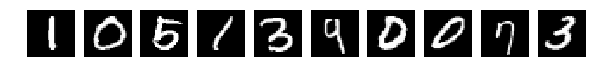

Reconstructions:


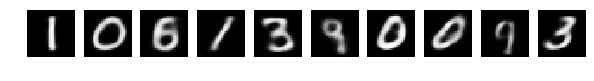

Generated Images:


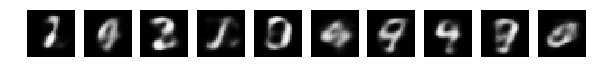

Train | Epoch: 14 [0/60000 (0%)]	Loss: 0.001298
Train | Epoch: 14 [12800/60000 (21%)]	Loss: 0.001275
Train | Epoch: 14 [25600/60000 (43%)]	Loss: 0.001284
Train | Epoch: 14 [38400/60000 (64%)]	Loss: 0.001318
Train | Epoch: 14 [51200/60000 (85%)]	Loss: 0.001302
====> Train | Epoch: 14 	 | 	 Average loss: 0.0013
====> Test  | model loss: 0.0012
Inputs:


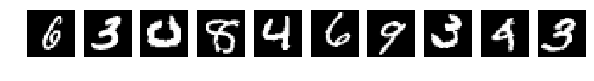

Reconstructions:


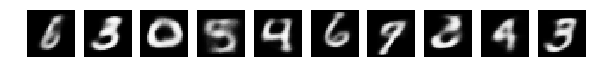

Generated Images:


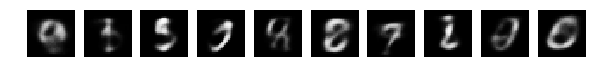

Train | Epoch: 15 [0/60000 (0%)]	Loss: 0.001243
Train | Epoch: 15 [12800/60000 (21%)]	Loss: 0.001265
Train | Epoch: 15 [25600/60000 (43%)]	Loss: 0.001338
Train | Epoch: 15 [38400/60000 (64%)]	Loss: 0.001258
Train | Epoch: 15 [51200/60000 (85%)]	Loss: 0.001257
====> Train | Epoch: 15 	 | 	 Average loss: 0.0013
====> Test  | model loss: 0.0012
Inputs:


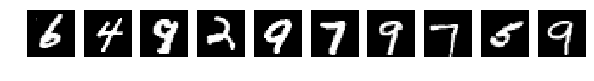

Reconstructions:


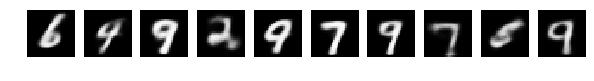

Generated Images:


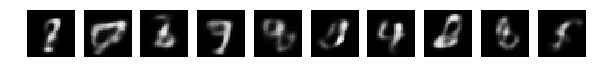

Train | Epoch: 16 [0/60000 (0%)]	Loss: 0.001260
Train | Epoch: 16 [12800/60000 (21%)]	Loss: 0.001224
Train | Epoch: 16 [25600/60000 (43%)]	Loss: 0.001246
Train | Epoch: 16 [38400/60000 (64%)]	Loss: 0.001279
Train | Epoch: 16 [51200/60000 (85%)]	Loss: 0.001276
====> Train | Epoch: 16 	 | 	 Average loss: 0.0013
====> Test  | model loss: 0.0012
Inputs:


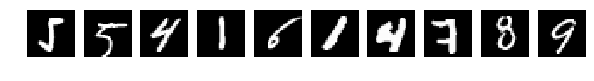

Reconstructions:


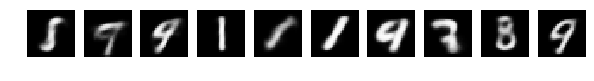

Generated Images:


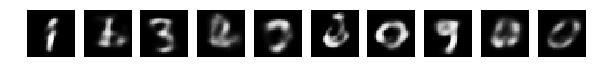

Train | Epoch: 17 [0/60000 (0%)]	Loss: 0.001220
Train | Epoch: 17 [12800/60000 (21%)]	Loss: 0.001250
Train | Epoch: 17 [25600/60000 (43%)]	Loss: 0.001283
Train | Epoch: 17 [38400/60000 (64%)]	Loss: 0.001327
Train | Epoch: 17 [51200/60000 (85%)]	Loss: 0.001258
====> Train | Epoch: 17 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0011
Inputs:


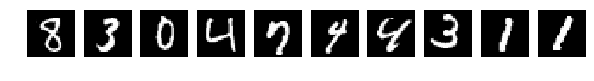

Reconstructions:


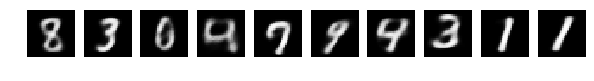

Generated Images:


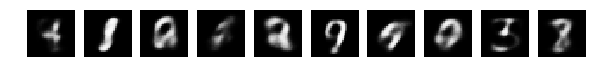

Train | Epoch: 18 [0/60000 (0%)]	Loss: 0.001240
Train | Epoch: 18 [12800/60000 (21%)]	Loss: 0.001211
Train | Epoch: 18 [25600/60000 (43%)]	Loss: 0.001225
Train | Epoch: 18 [38400/60000 (64%)]	Loss: 0.001186
Train | Epoch: 18 [51200/60000 (85%)]	Loss: 0.001239
====> Train | Epoch: 18 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0011
Inputs:


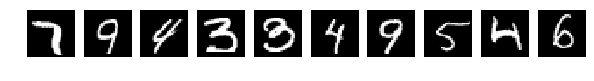

Reconstructions:


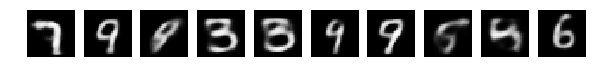

Generated Images:


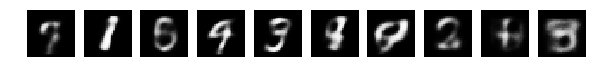

Train | Epoch: 19 [0/60000 (0%)]	Loss: 0.001217
Train | Epoch: 19 [12800/60000 (21%)]	Loss: 0.001210
Train | Epoch: 19 [25600/60000 (43%)]	Loss: 0.001183
Train | Epoch: 19 [38400/60000 (64%)]	Loss: 0.001216
Train | Epoch: 19 [51200/60000 (85%)]	Loss: 0.001200
====> Train | Epoch: 19 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0011
Inputs:


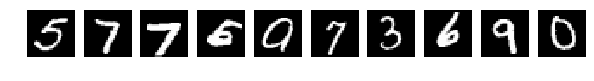

Reconstructions:


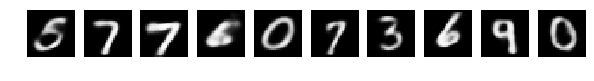

Generated Images:


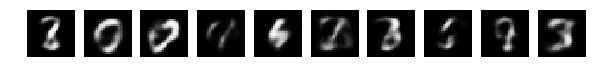

Train | Epoch: 20 [0/60000 (0%)]	Loss: 0.001215
Train | Epoch: 20 [12800/60000 (21%)]	Loss: 0.001244
Train | Epoch: 20 [25600/60000 (43%)]	Loss: 0.001225
Train | Epoch: 20 [38400/60000 (64%)]	Loss: 0.001185
Train | Epoch: 20 [51200/60000 (85%)]	Loss: 0.001195
====> Train | Epoch: 20 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0011
Inputs:


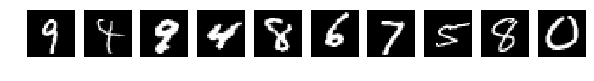

Reconstructions:


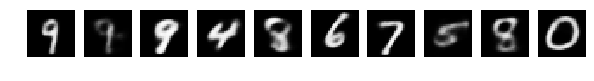

Generated Images:


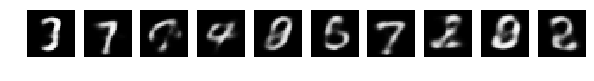

Train | Epoch: 21 [0/60000 (0%)]	Loss: 0.001199
Train | Epoch: 21 [12800/60000 (21%)]	Loss: 0.001232
Train | Epoch: 21 [25600/60000 (43%)]	Loss: 0.001193
Train | Epoch: 21 [38400/60000 (64%)]	Loss: 0.001223
Train | Epoch: 21 [51200/60000 (85%)]	Loss: 0.001199
====> Train | Epoch: 21 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0011
Inputs:


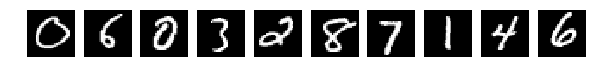

Reconstructions:


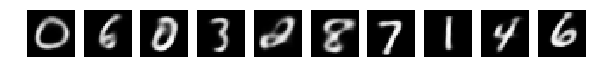

Generated Images:


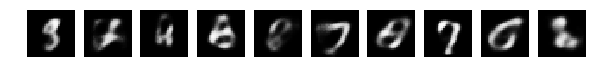

Train | Epoch: 22 [0/60000 (0%)]	Loss: 0.001239
Train | Epoch: 22 [12800/60000 (21%)]	Loss: 0.001159
Train | Epoch: 22 [25600/60000 (43%)]	Loss: 0.001178
Train | Epoch: 22 [38400/60000 (64%)]	Loss: 0.001237
Train | Epoch: 22 [51200/60000 (85%)]	Loss: 0.001156
====> Train | Epoch: 22 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0011
Inputs:


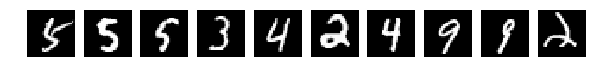

Reconstructions:


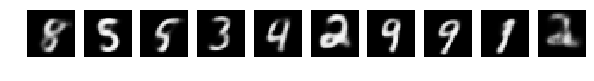

Generated Images:


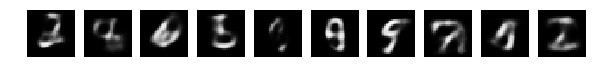

Train | Epoch: 23 [0/60000 (0%)]	Loss: 0.001182
Train | Epoch: 23 [12800/60000 (21%)]	Loss: 0.001192
Train | Epoch: 23 [25600/60000 (43%)]	Loss: 0.001161
Train | Epoch: 23 [38400/60000 (64%)]	Loss: 0.001189
Train | Epoch: 23 [51200/60000 (85%)]	Loss: 0.001173
====> Train | Epoch: 23 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0011
Inputs:


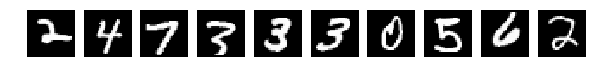

Reconstructions:


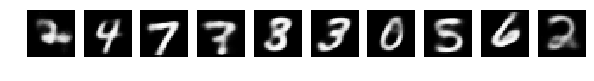

Generated Images:


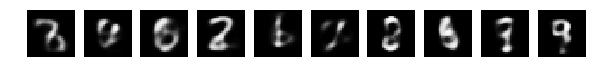

Train | Epoch: 24 [0/60000 (0%)]	Loss: 0.001204
Train | Epoch: 24 [12800/60000 (21%)]	Loss: 0.001151
Train | Epoch: 24 [25600/60000 (43%)]	Loss: 0.001195
Train | Epoch: 24 [38400/60000 (64%)]	Loss: 0.001186
Train | Epoch: 24 [51200/60000 (85%)]	Loss: 0.001177
====> Train | Epoch: 24 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0011
Inputs:


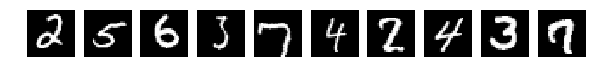

Reconstructions:


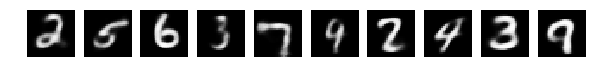

Generated Images:


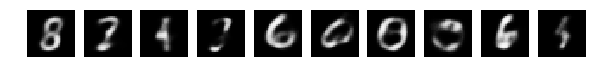

Train | Epoch: 25 [0/60000 (0%)]	Loss: 0.001199
Train | Epoch: 25 [12800/60000 (21%)]	Loss: 0.001206
Train | Epoch: 25 [25600/60000 (43%)]	Loss: 0.001169
Train | Epoch: 25 [38400/60000 (64%)]	Loss: 0.001199
Train | Epoch: 25 [51200/60000 (85%)]	Loss: 0.001187
====> Train | Epoch: 25 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0011
Inputs:


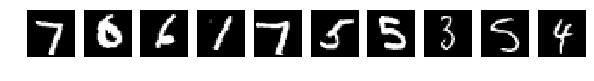

Reconstructions:


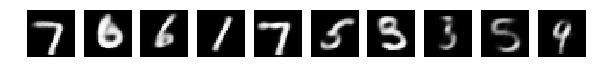

Generated Images:


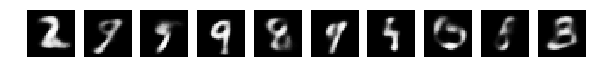

Train | Epoch: 26 [0/60000 (0%)]	Loss: 0.001164
Train | Epoch: 26 [12800/60000 (21%)]	Loss: 0.001190
Train | Epoch: 26 [25600/60000 (43%)]	Loss: 0.001162
Train | Epoch: 26 [38400/60000 (64%)]	Loss: 0.001206
Train | Epoch: 26 [51200/60000 (85%)]	Loss: 0.001164
====> Train | Epoch: 26 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0011
Inputs:


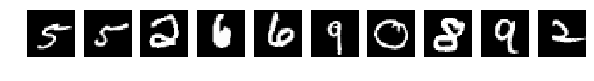

Reconstructions:


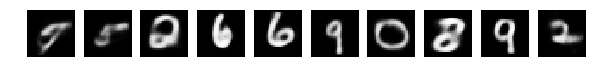

Generated Images:


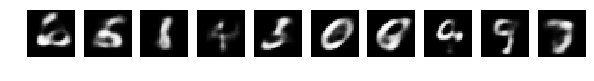

Train | Epoch: 27 [0/60000 (0%)]	Loss: 0.001167
Train | Epoch: 27 [12800/60000 (21%)]	Loss: 0.001172
Train | Epoch: 27 [25600/60000 (43%)]	Loss: 0.001150
Train | Epoch: 27 [38400/60000 (64%)]	Loss: 0.001194
Train | Epoch: 27 [51200/60000 (85%)]	Loss: 0.001182
====> Train | Epoch: 27 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0011
Inputs:


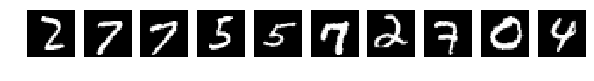

Reconstructions:


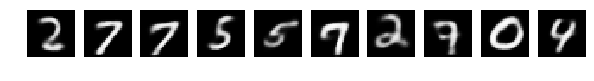

Generated Images:


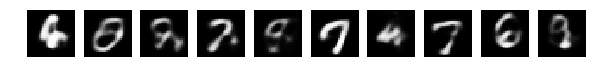

Train | Epoch: 28 [0/60000 (0%)]	Loss: 0.001152
Train | Epoch: 28 [12800/60000 (21%)]	Loss: 0.001179
Train | Epoch: 28 [25600/60000 (43%)]	Loss: 0.001164
Train | Epoch: 28 [38400/60000 (64%)]	Loss: 0.001161
Train | Epoch: 28 [51200/60000 (85%)]	Loss: 0.001128
====> Train | Epoch: 28 	 | 	 Average loss: 0.0012
====> Test  | model loss: 0.0010
Inputs:


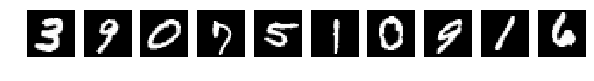

Reconstructions:


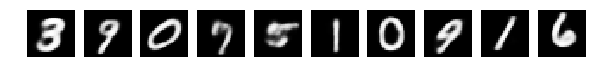

Generated Images:


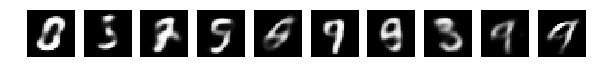

Train | Epoch: 29 [0/60000 (0%)]	Loss: 0.001126
Train | Epoch: 29 [12800/60000 (21%)]	Loss: 0.001049
Train | Epoch: 29 [25600/60000 (43%)]	Loss: 0.001159
Train | Epoch: 29 [38400/60000 (64%)]	Loss: 0.001132
Train | Epoch: 29 [51200/60000 (85%)]	Loss: 0.001140
====> Train | Epoch: 29 	 | 	 Average loss: 0.0011
====> Test  | model loss: 0.0010
Inputs:


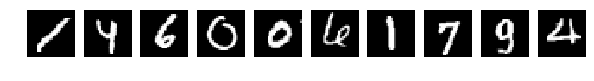

Reconstructions:


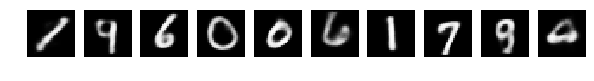

Generated Images:


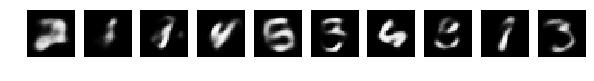

Train | Epoch: 30 [0/60000 (0%)]	Loss: 0.001162
Train | Epoch: 30 [12800/60000 (21%)]	Loss: 0.001124
Train | Epoch: 30 [25600/60000 (43%)]	Loss: 0.001115
Train | Epoch: 30 [38400/60000 (64%)]	Loss: 0.001148
Train | Epoch: 30 [51200/60000 (85%)]	Loss: 0.001168
====> Train | Epoch: 30 	 | 	 Average loss: 0.0011
====> Test  | model loss: 0.0010
Inputs:


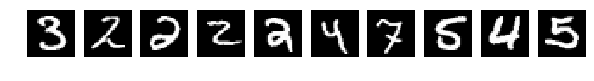

Reconstructions:


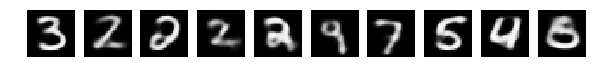

Generated Images:


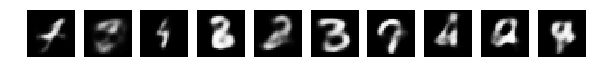

In [15]:
n_epoch = 30
run(vae, vae.parameters(), n_epoch, train_loader, test_loader,
   end_function=show_vae)

---

In [26]:
def check_interpolations(model, n_rows, n_cols):
    """
    Write a function which interpolates 10 images between two random mnist image
    """
    plt.rcParams['figure.figsize'] = (0.0 + n_cols, 0.0 + n_rows) # set default size of plots
    
    data_loader = train_loader
    output = []
    for _ in range(n_rows):
        indices = torch.randint(data_loader.dataset.tensors[0].shape[0], (2,))
        img_1 = data_loader.dataset.tensors[0][indices][:1].flatten(start_dim=1)
        img_2 = data_loader.dataset.tensors[0][indices][1:].flatten(start_dim=1)
        
    
        z_1 = vae(img_1)["z"]
        z_2 = vae(img_2)["z"]
        z = torch.cat((z_1, z_2), 0)
        z = z[None,:,:]
        z = z[None,:,:,:]
        interp = F.interpolate(z,size=(n_cols - 2, z_1.shape[1]), mode='bilinear')
        interp = interp[0,0]
        generated_img = vae.decoder(interp)
        output = torch.cat((img_1, generated_img, img_2), 0)
        output = output.detach().cpu().view(-1, 28, 28).numpy()
        ########################## TODO ##########################
        # Output `n_cols` images.
        # First one should be img_1. Last one should by img_2
        # Let z_1 and z_2 be latent tensors of img_1 and img_2
        # Interpolate (n_cols - 2) tensors between z_1 and z_2
        # Intermediate images must be the result of applying decoder on these (n_cols - 2) tensors
        ######################## END TODO ########################
    
        show(output)

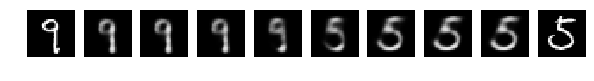

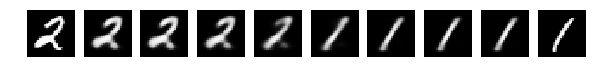

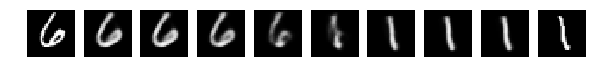

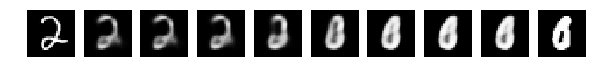

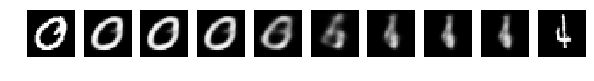

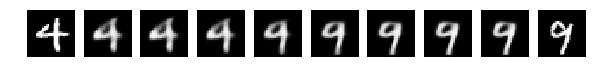

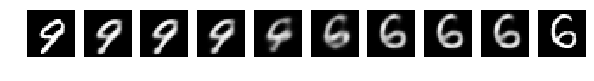

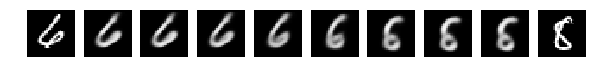

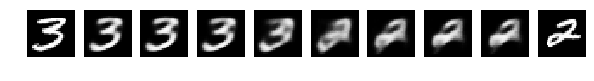

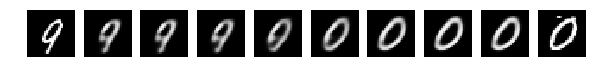

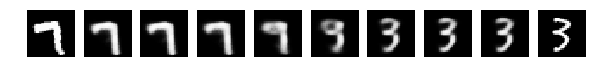

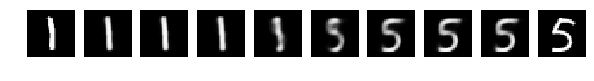

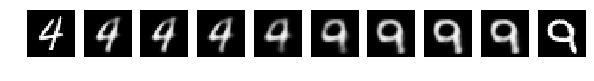

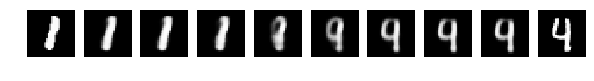

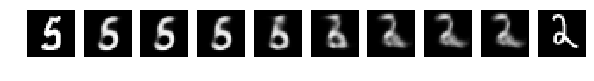

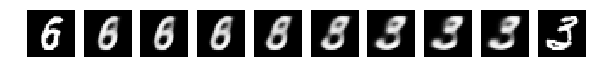

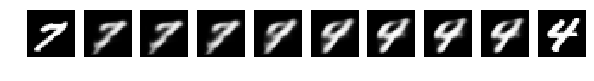

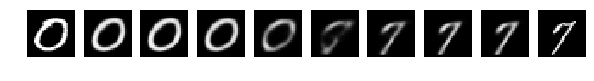

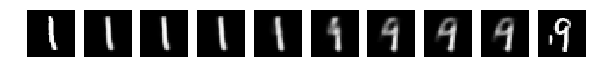

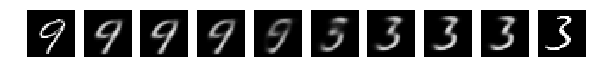

In [27]:
check_interpolations(vae, 20, 10)